In [2]:
import h5py
import cv2
import warp_norm
import matplotlib
import sys
sys.path.append("./FaceAlignment")
import face_alignment
from skimage import io
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from model import gaze_network
from torchvision import transforms
import utils
import pickle
import pandas as pd

with open('./gaze_pred.pkl', 'rb') as fo:
    tinydict = pickle.load(fo, encoding='bytes')

In [3]:
file_names = tinydict['file_name']
file_dict = []
for file_name in file_names:
    file_name = str(file_name).strip('()').split(',')
    for file in file_name:
        file_dict.append(int(file.strip("''").split('/')[6].split('.')[0][19:]))
        # print(file.strip("''").split('/')[6].split('.')[0][19:])
print(file_dict)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 199, 200, 201, 202, 203, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 22

In [4]:
with open('/home/hgh/hghData/Datasets/dataset_dict.pkl', 'rb') as fo:
    tinydict2 = pickle.load(fo, encoding='bytes')

In [5]:
ground_truth = [[],[],[],[],[],[],[],[]]
pred = [[],[],[],[],[],[],[],[]]
RMat = [[],[],[],[],[],[],[],[]]
for i in range(len(file_dict)):
    number = int((file_dict[i] - 1)/100)
    ground_truth[number].append(tinydict['label'][i])
    pred[number].append(tinydict['pred_gaze'][i])
    RMat[number].append(tinydict2[i]['R'])
for i in range(len(ground_truth)):
    ground_truth[i] = np.vstack(ground_truth[i])
    pred[i] = np.vstack(pred[i])
print(RMat[0][0])

[[ 0.99934383 -0.03606395  0.00336276]
 [ 0.03610734  0.99925146 -0.01388445]
 [-0.00285951  0.01399676  0.99989795]]


In [6]:
# 将pitchyaw转换成vector
for i in range(len(ground_truth)):
    pred[i] = warp_norm.pitchyaw_to_vector(pred[i])

print(pred[0][0])

# 将归一化向量还原
org_pred = [[],[],[],[],[],[],[],[]]
for i in range(len(ground_truth)):
    for j in range(len(RMat[i])):
        print(RMat[i][j])
        org_pred[i].append(np.dot(np.linalg.inv(RMat[i][j]), pred[i][j].T))
print(org_pred[0][0])

[-0.16203392 -0.14296676  0.97637366]
[[ 0.99934383 -0.03606395  0.00336276]
 [ 0.03610734  0.99925146 -0.01388445]
 [-0.00285951  0.01399676  0.99989795]]
[[ 0.99973859 -0.02249691  0.00407825]
 [ 0.02256111  0.99961019 -0.0164456 ]
 [-0.00370668  0.01653332  0.99985644]]
[[ 0.99983164 -0.01774629  0.00466459]
 [ 0.01781641  0.99972196 -0.01544613]
 [-0.00438918  0.01552664  0.99986982]]
[[ 0.99965685 -0.02579486  0.00456191]
 [ 0.02585625  0.99956829 -0.0139534 ]
 [-0.00420001  0.01406656  0.99989224]]
[[ 0.99983171 -0.01708909  0.00667257]
 [ 0.01721608  0.99966237 -0.01946139]
 [-0.00633774  0.01957299  0.99978834]]
[[ 0.99985343 -0.01577098  0.00666264]
 [ 0.01588798  0.99971373 -0.01788933]
 [-0.0063786   0.01799256  0.99981777]]
[[ 0.99980547 -0.01829084  0.00738018]
 [ 0.01846575  0.99953239 -0.02437266]
 [-0.00693093  0.0245042   0.9996757 ]]
[[ 0.99997291  0.00648562  0.00348082]
 [-0.00640674  0.99973275 -0.02221199]
 [-0.00362395  0.02218908  0.99974722]]
[[ 9.99821443e-01 

In [7]:
pixel_scale_tan = np.array([0.211667, 0.211667])
pixel_scale_chen = np.array([0.223427, 0.223427])

pred_gc = [[],[],[],[],[],[],[],[]]
for i in range(len(ground_truth)):
    for j in range(len(pred[i])):
        if i%2 == 0:
            pred_gc[i].append(warp_norm.vector_to_gc(pred[i][j], pixel_scale_tan))
        else:
            pred_gc[i].append(warp_norm.vector_to_gc(pred[i][j], pixel_scale_chen))
print(pred_gc[0])

[array([-470.42238545,  415.06595685]), array([-49.36013811, 550.24414604]), array([261.63642046, 292.79717562]), array([540.29609439, 391.10872004]), array([353.3375898 , 630.48352098]), array([439.5570338 , 365.43990524]), array([500.83245272, 809.58978815]), array([233.84104025, 278.6534651 ]), array([-660.49551676,  446.72895892]), array([-673.4726885 ,  348.52870794]), array([-101.30828537,  265.53925197]), array([-522.07618107,  254.71739536]), array([-351.79548338,  450.78858863]), array([ 93.89831078, 413.82883515]), array([183.55964412, 336.58214095]), array([-360.22998135,  700.37555767]), array([126.24922278, 838.79126919]), array([422.71562088, 614.10667569]), array([ 29.56856016, 362.14942294]), array([241.53109912, 503.25898082]), array([ 35.19163247, 334.16602111]), array([-574.43199919,  169.82851786]), array([396.1386817 , 662.02153985]), array([ 80.44670064, 640.27491562]), array([331.27944132, 589.69670982]), array([-191.48355344,  661.13189792]), array([512.50846346

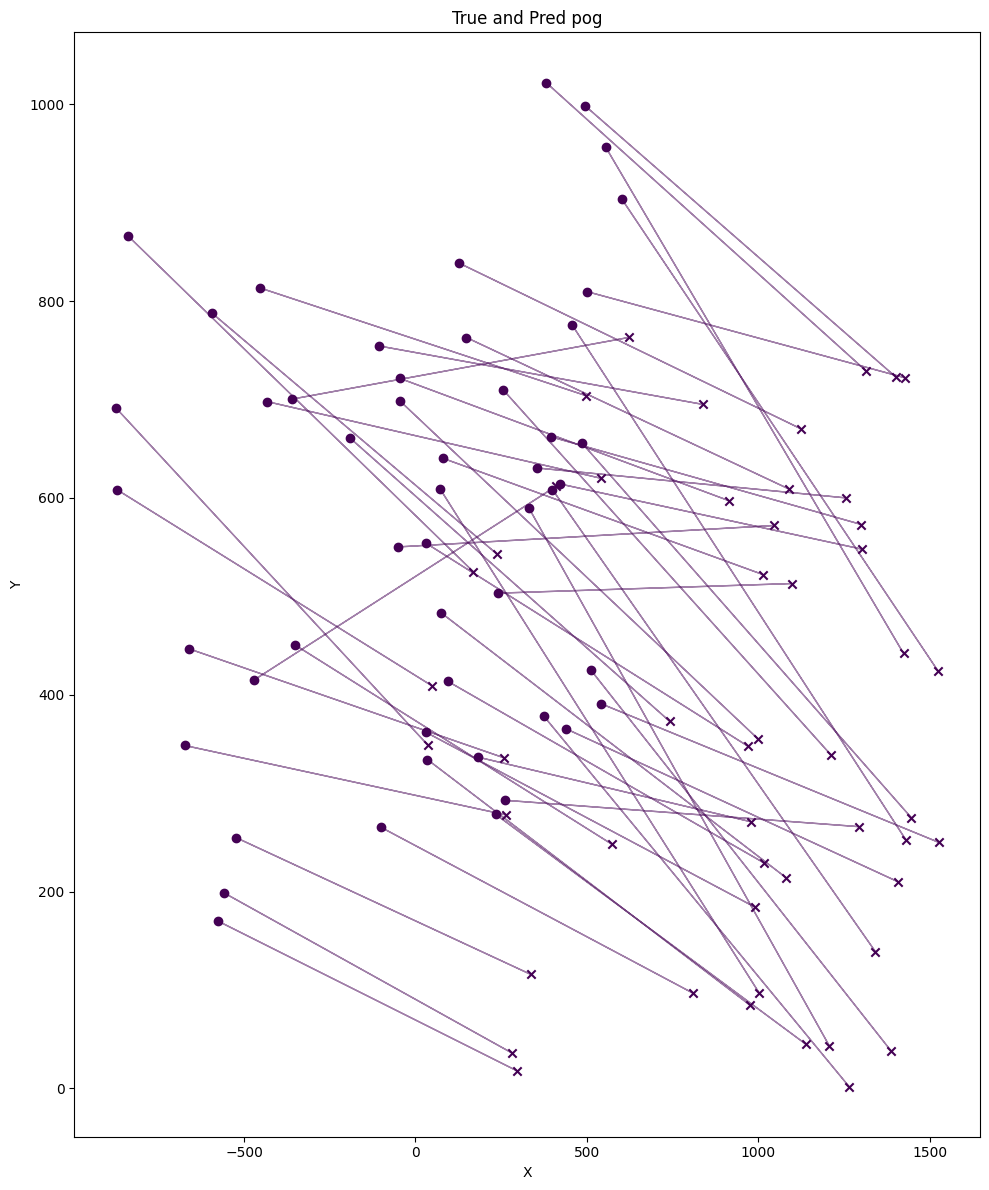

In [9]:
plt.figure(figsize=(10, 12))

colors = plt.cm.viridis(np.linspace(0, 1, 8))

i = 0
for j in range(len(pred[i])):
    if j < 50:
        plt.scatter(pred_gc[i][j][0], pred_gc[i][j][1], marker='o',color = colors[i], label=f'Measured')
        plt.scatter(ground_truth[i][j][0], ground_truth[i][j][1], marker='x',color = colors[i], label=f'True')
        plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], pred_gc[i][j][0] - ground_truth[i][j][0], pred_gc[i][j][1] - ground_truth[i][j][1], color=colors[i], alpha=0.5)

plt.title('True and Pred pog')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()

plt.tight_layout()
plt.show()


[ 930.91833277 -207.99408601]


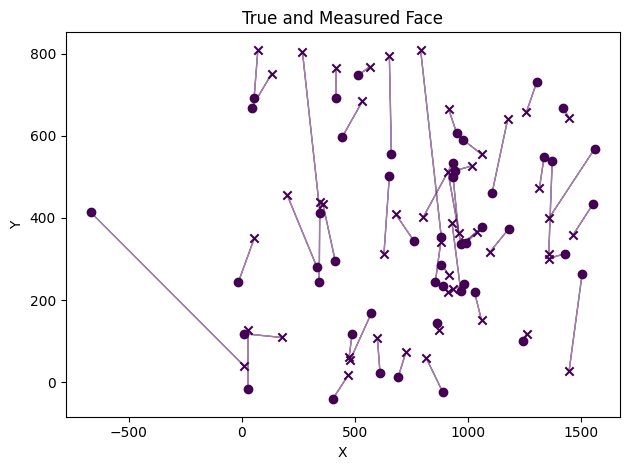

In [21]:
org = np.mean(ground_truth[0][0:50],axis=0) - np.mean(pred_gc[0][0:50],axis=0)
print(org)
pred_gc_org = org + pred_gc[0]

i = 0
for j in range(len(pred[i])):
    if j > 50:
        plt.scatter(pred_gc_org[j][0], pred_gc_org[j][1], marker='o',color = colors[i], label=f'Measured')
        plt.scatter(ground_truth[i][j][0], ground_truth[i][j][1], marker='x',color = colors[i], label=f'True')
        plt.arrow(ground_truth[i][j][0], ground_truth[i][j][1], pred_gc_org[j][0] - ground_truth[i][j][0], pred_gc_org[j][1] - ground_truth[i][j][1], color=colors[i], alpha=0.5)

plt.title('True and Measured Face')
plt.xlabel('X')
plt.ylabel('Y')
# plt.legend()

plt.tight_layout()
plt.show()